In [2]:
import numpy as np
import pyccl as ccl
import py_cosmo_mad as csm
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker, cm

from mpl_toolkits.mplot3d import axes3d
#from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [3]:
# set up cosmologies in CCL
p1 = ccl.Parameters(Omega_c=0.25, Omega_b=0.05, h=0.7, sigma8=0.80, n_s=0.96, w0=-1.0, wa=0.0)
p2 = ccl.Parameters(Omega_c=0.25, Omega_b=0.05, h=0.7, sigma8=0.80, n_s=0.96, w0=-0.9, wa=0.0)
p3 = ccl.Parameters(Omega_c=0.25, Omega_b=0.05, h=0.7, sigma8=0.80, n_s=0.96, w0=-0.9, wa=0.1)
p4 = ccl.Parameters(Omega_c=0.25, Omega_b=0.05, h=0.7, sigma8=0.80, n_s=0.96, w0=-0.9, wa=0.1)
p5 = ccl.Parameters(Omega_c=0.25, Omega_b=0.05, h=0.7, sigma8=0.80, n_s=0.96, w0=-0.9, wa=0.1)

p1.parameters.Omega_g = 0
p2.parameters.Omega_g = 0
p3.parameters.Omega_g = 0
p4.parameters.Omega_g = 0
p5.parameters.Omega_g = 0

p4.parameters.Omega_l = 0.65
p5.parameters.Omega_l = 0.75

# define the cosmology model to use
p = p3
fname = 'model3_xiRSD.txt' # filename for writing benchmark data
cosmo = ccl.Cosmology(p)

In [4]:
nk = 10000 # No. of points in k
ns = 5000 # No. of points in s
k_arr = np.logspace(-4.7,5,nk)
s_arr = np.logspace(-1,3,ns)
a = 1.0 # scale factor
h = 0.7 # Hubble

In [5]:
# CCL power spectra
pk_lin = ccl.linear_matter_power(cosmo, k_arr, a)
pk_nl = ccl.nonlin_matter_power(cosmo, k_arr, a)

In [6]:
# write power spectra to files to be read by CosmoMAD (Note: k is in units of h Mpc^-1 in CosmoMAD but Mpc^-1 in CCL)
file1 = open('pk_lin.dat','w') 
for n in range(nk):
    file1.write(str(k_arr[n]/h)+'   '+str(pk_lin[n])+'\n') 
file1.close()

file2 = open('pk_nl.dat','w') 
for n in range(nk):
    file2.write(str(k_arr[n]/h)+'   '+str(pk_nl[n])+'\n') 
file2.close()

In [7]:
# Input CCL P(k)'s to CosmoMAD 
pcsp=csm.PcsPar()
oc = p.parameters.Omega_c
ob = p.parameters.Omega_b
s8 = p.parameters.sigma8
ns = p.parameters.n_s
w0 = p.parameters.w0
wa = p.parameters.wa
pcsp.background_set(oc+ob,h,ob,w0,wa,h,2.725);
pcsp.set_linear_pk("pk_lin.dat",-5,1,0.005,ns,s8)
pcsp.set_nonlinear_pk("pk_nl.dat")

beta = pcsp.f_growth(a) # we assume bias = 1 and get growth factor from CosmoMAD
print('beta =', beta)
pcsp.set_Pk_params(beta,pcsp.growth_factor(a)/pcsp.growth_factor(1),1.0,4);

beta = 0.5102500557881973


In [8]:
# Calculate correlation function in CosmoMAD (Note: s in in units of Mpc/h in CosmoMAD but Mpc in CCL)
def xicosmomad (s_arr):
    xi = []
    for s in s_arr:
        # xi.append(pcsp.xi_multipole(s*h,0) + 1./4*pcsp.xi_multipole(s*h,2) + 9./64*pcsp.xi_multipole(s*h,4))
        xi.append(pcsp.xi_multipole(s*h,0))
    return np.array(xi)

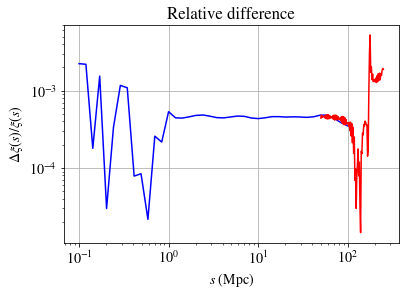

Max frac diff for s = 0.1-100: 0.0022304055301746173
Max frac diff for s = 50-250: 0.00524041274616216


In [9]:
# Plot relative and absolute differences
frac_diff1 = []
frac_diff2 = []
abs_diff1 = []    
abs_diff2 = []

s1 = np.logspace(-1,2,40)
s2 = np.logspace(np.log10(50),np.log10(250),100)

xi_ccl1 = ccl.correlation_3dRsd_avgmu(cosmo,a,s1,beta)
xi_cosmomad1 = xicosmomad(s1)

xi_ccl2 = ccl.correlation_3dRsd_avgmu(cosmo,a,s2,beta)
xi_cosmomad2 = xicosmomad(s2)

for i in range(len(s1)):
    frac_diff1.append(np.abs(xi_ccl1[i]/xi_cosmomad1[i] - 1.))
    abs_diff1.append(np.abs(s1[i]*s1[i]*(xi_ccl1[i]-xi_cosmomad1[i])))
    
for i in range(len(s2)):
    frac_diff2.append(np.abs(xi_ccl2[i]/xi_cosmomad2[i] - 1.))
    abs_diff2.append(np.abs(s2[i]*s2[i]*(xi_ccl2[i]-xi_cosmomad2[i])))
    

# esthetic definitions for the plots
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 14

plt.plot(s1, frac_diff1, 'b-')
plt.plot(s2, frac_diff2, 'r-')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$s$ (Mpc)')
plt.ylabel(r'$\Delta \xi(s) / \xi(s)$')
plt.grid(which='major')
plt.title('Relative difference') 
#plt.savefig('benchmark_rel.pdf',bbox_inches = 'tight')
plt.show()
#print frac_diff
print(f'Max frac diff for s = 0.1-100: {np.amax(frac_diff1)}')
print(f'Max frac diff for s = 50-250: {np.amax(frac_diff2)}')

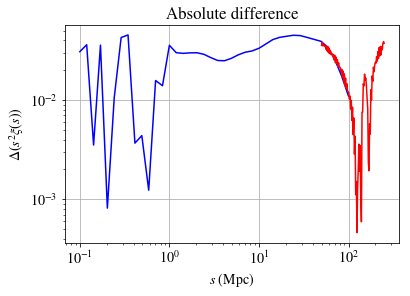

Max diff for s = 0.1-100: 0.04527382016672736
Max diff for s = 50-250: 0.038796943897711024
BAO peak height = max (s^2 xi) for s = 140-160 Mpc: 51.71152471864682
Average Delta(r^2 xi) for s = 140-150 Mpc: 0.010881527323687957


In [10]:
r2xi = np.array(s2*s2*xi_cosmomad2)

# plot absolute difference in r^2 xi(r)
plt.plot(s1, abs_diff1, 'b-')
plt.plot(s2, abs_diff2, 'r-')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$s$ (Mpc)')
plt.ylabel(r'$\Delta (s^2 \xi(s)) $')
plt.grid(which='minor')
plt.title('Absolute difference') 
plt.grid(which='both')
#plt.savefig('benchmark_abs.pdf',bbox_inches = 'tight')
plt.show()

#print abs_diff
print(f'Max diff for s = 0.1-100: {np.amax(abs_diff1)}')
print(f'Max diff for s = 50-250: {np.amax(abs_diff2)}')
apex = np.amax(r2xi[(s2<160)&(s2>140)])
print(f'BAO peak height = max (s^2 xi) for s = 140-160 Mpc: {apex}')
# find and print the average of Delta(r^2 xi) in the BAO peak region
avg_value = np.average(np.array(abs_diff2)[(140<s2) & (s2<150)])
print(f'Average Delta(r^2 xi) for s = 140-150 Mpc: {avg_value}')

In [11]:
# Write benchmark data to file
f = open(fname,'w')

f.write('#  [0] s (Mpc; comoving), [1] xi(s,z=0.0)' + '\n')

for i in range(len(s1)):
    col = []
    s = ''
    col.append("{:.18e}".format(s1[i]).ljust(27))
    col.append("{:.18e}".format(xi_cosmomad1[i]).ljust(27))
    s = s + col[0] + col[1] 
    f.write(s + '\n')

for i in range(len(s2)):
    col = []
    s = ''
    col.append("{:.18e}".format(s2[i]).ljust(27))
    col.append("{:.18e}".format(xi_cosmomad2[i]).ljust(27))
    s = s + col[0] + col[1]        
    f.write(s + '\n')

f.close()

In [12]:
# Make some plots of the difference s^2*xi(CCL) - s^2*xi(CosmoMAD) for xi(pi, sigma)
def bench_pi_sigma(pi,sigma):
    xi = []
    for sig in sigma:
        xi.append(pcsp.xi_pi_sigma(pi*h,sig*h,1))
    return np.array(xi)

In [13]:
N = 200
l = 200
pi = np.linspace(0,l,N)
sigma = np.linspace(0,l,N)

X = np.ones([N,N]);
for i in range(N):
    bench_xi = bench_pi_sigma(pi[i],sigma);
    ccl_xi = ccl.correlation_pi_sigma(cosmo,a,beta,pi[i],sigma,True);
    #X[i] = np.abs(1 - ccl_xi/bench_xi)
    X[i] = np.absolute(ccl_xi - bench_xi) * (pi[i]**2 + sigma[i]**2)

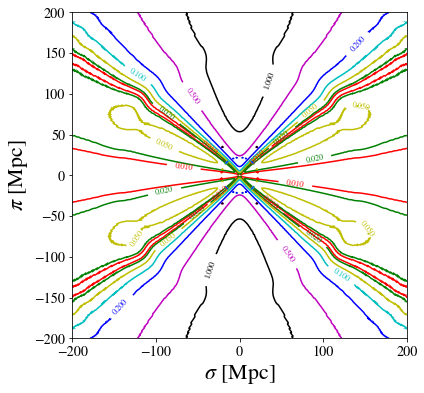

In [14]:
x = np.linspace(-l,l,2*N)
y = np.linspace(-l,l,2*N)
b1 = np.hstack((np.fliplr(X),X))
b2 = np.flipud(b1)
b = np.vstack((b2,b1))

#v = [0.0001,0.0002,0.0005,0.001,0.002,0.005,0.01]
v = [0.01,0.02,0.05,0.1,0.2,0.5,1.]
plt.figure(figsize = (6,6))
CP=plt.contour(x,y,b,v,colors=('r', 'g', 'y', 'c', 'b', 'm', 'k'))
plt.clabel(CP, inline=1, fontsize=8)
plt.xlabel(r'$\sigma$ $[\rm{Mpc}]$',fontsize=22)
plt.ylabel(r'$\pi$ $[\rm{Mpc}]$',fontsize=22)
#plt.grid()
#plt.savefig('benchmark1.pdf',bbox_inches = 'tight')
plt.show()

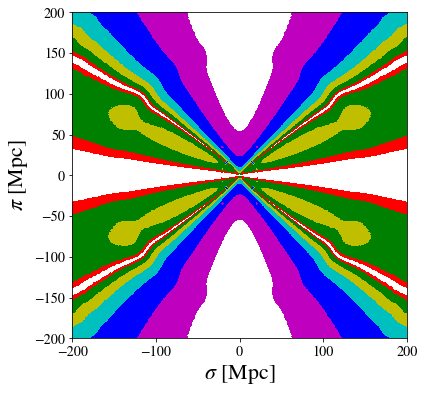

In [15]:
plt.figure(figsize = (6,6))
plt.contourf(x,y,b,v,colors=('r', 'g', 'y', 'c', 'b', 'm', 'k'))
#plt.clabel(CP, inline=1, fontsize=12)
plt.xlabel(r'$\sigma$ $[\rm{Mpc}]$',fontsize=22)
plt.ylabel(r'$\pi$ $[\rm{Mpc}]$',fontsize=22)
#plt.grid()
#plt.savefig('benchmark2.pdf',bbox_inches = 'tight')
plt.show()

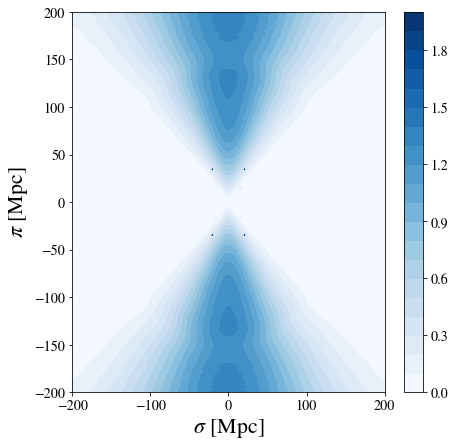

In [24]:
fig, ax = plt.subplots(figsize=(7, 7)) 
ax.set_xlabel(r'$\sigma$ $[\rm{Mpc}]$',fontsize=22)
ax.set_ylabel(r'$\pi$ $[\rm{Mpc}]$',fontsize=22)
#csp=plt.contourf(x, y, b, locator=ticker.LogLocator(), cmap=cm.PuBu_r)
#cbar = fig.colorbar(csp)

plt.contourf(x, y, b, 20, cmap='Blues')
plt.colorbar();

#plt.savefig('benchmark3.pdf',bbox_inches = 'tight')

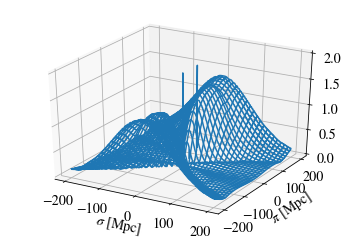

In [17]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(111, projection='3d')
X, Y = np.meshgrid(x, y)
ax1.plot_wireframe(X, Y, b, rstride=10, cstride=10)
ax1.set_xlabel(r'$\sigma$ $[\rm{Mpc}]$',fontsize=14)
ax1.set_ylabel(r'$\pi$ $[\rm{Mpc}]$',fontsize=14)
#ax1.set_zscale('log')
zlimits=ax1.set_zlim(0., 2.)
#plt.savefig('benchmark4.pdf',bbox_inches = 'tight')